In [57]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import keras
x = loadmat('training_input_v2.mat')
y=loadmat('training_output_v3.mat')
training_input=x['training_input']
# convert to np array
shape_scores=np.array(y['shape_scores'].tolist())

In [34]:
input_data=np.zeros((1,139,3))
x=loadmat('curves.mat')
x_values=list(x.values())
x_array=np.array(x_values[-1])
if x_array.shape == (3,100):
    print(x_array.shape)
else: 
    input_data[None,:,:]=x_array.T


In [35]:
input_data.shape

(1, 139, 3)

In [36]:
x_array.shape != (3,100)

True

In [37]:
# assume data read from matlab is 3-dimension with 
# (numo of examples, rows or called number of points in a curve, columns or called num of feature for each point)
num_of_samples=training_input.shape[0]
row_of_sample,column_of_sample=training_input[0][0].shape
# unpack data and reshape their dimension to (num of curves, num of features for each point,number of points in each curve)
data=np.zeros((num_of_samples,column_of_sample,row_of_sample))
i=0
for curve in training_input:
    one_curve=np.array(curve[0].tolist()).T
    data[i,:,:]+=one_curve
    i+=1

In [38]:
# convert y shape_score to one-hot representation
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y
shape_scores_oh=convert_to_one_hot(shape_scores,3)

In [39]:
print(shape_scores_oh.shape)
print(data.shape)

(3000, 3)
(3000, 100, 3)


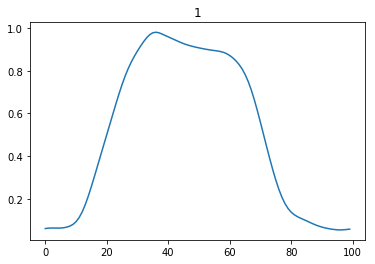

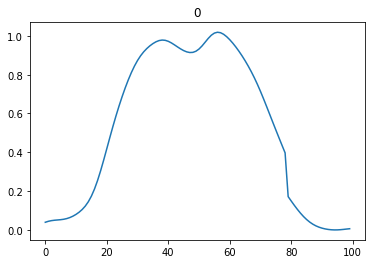

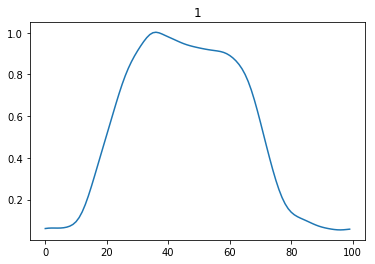

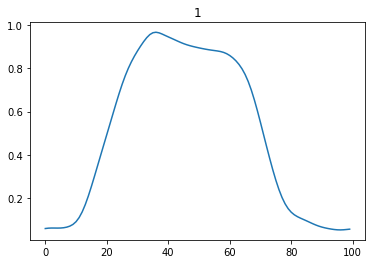

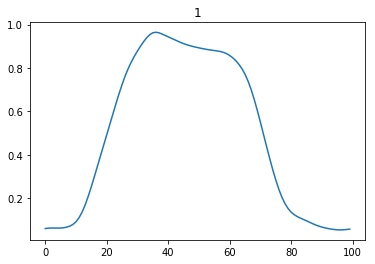

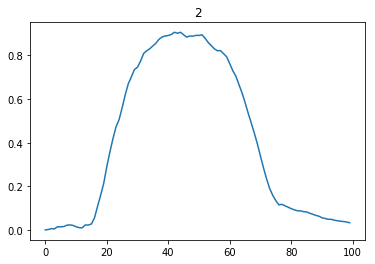

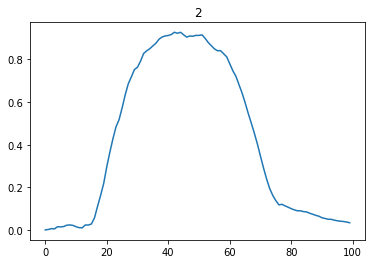

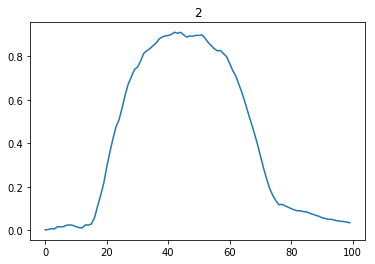

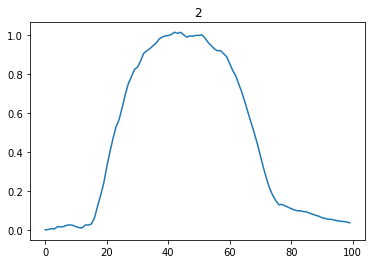

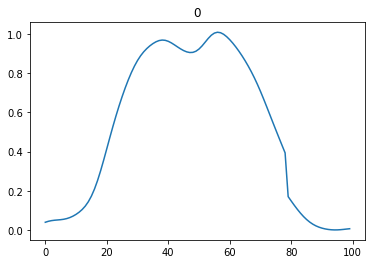

In [10]:
# shuffle origin data and divide it into training and testing dataset
np.random.seed(1)
permutation = list(np.random.permutation(shape_scores_oh.shape[0]))
shuffled_X = data[permutation,:,:]
shuffled_Y = shape_scores_oh[permutation,:]
# 0~2399 are training, 2400~3000 are testing
trained_X=shuffled_X[:2400,:,:]
trained_Y=shuffled_Y[:2400,:]
test_X=shuffled_X[2400:,:,:]
test_Y=shuffled_Y[2400:,:]

# randomly plot some curves to make sure that curves and their category are correct
import matplotlib.pyplot as plt
for i in range(10):
    plt.plot(shuffled_X[i, :, 0])
    plt.title(str(np.argmax(shuffled_Y[i, :])))
    plt.show()

In [58]:
def kfold_scores(alg,x_train,y_train,is_nn=False):
    from sklearn.model_selection import KFold
    from sklearn.metrics import log_loss
    import keras
    kf = KFold(n_splits = 3, random_state= 1, shuffle=True)
    predict_y = []
    
    callbacks_list = [
        keras.callbacks.EarlyStopping(
        monitor='acc',
        patience=1,
        )
    ]
    if is_nn:
        alg.save_weights('initial_weights.h5')
        
    for kf_train,kf_test in kf.split(x_train):
        if is_nn:
            alg.load_weights('initial_weights.h5')
            alg.fit(x_train[kf_train],y_train[kf_train],epochs=10,callbacks=callbacks_list,validation_data=(x_train[kf_test],y_train[kf_test]),verbose=2,batch_size = 32, shuffle=True)
        else:
            alg.fit(x_train[kf_train],y_train[kf_train])
        y_pred_train = alg.predict(x_train[kf_test])
        ll = log_loss(y_train[kf_test],y_pred_train)
        predict_y.append(ll)
    
    cv_ll=np.mean(predict_y)
    print("交叉验证集log_loss均值为 %s" % (np.mean(predict_y)))  
    return cv_ll

In [ ]:
min_cv_ll=10
min_test_ll=10
min_cv_ll_parameters=[]
min_test_ll_parameters=[]
for num_of_units in [64,128,256,512]:
    for drop_out_rate in [0,0.1,0.2,0.3,0.4,0.5]:
        print('num of units is {}, dropout rate is {}'.format(num_of_units,drop_out_rate))
        cv_ll_list=[]
        test_ll_list=[]
        model=movement_shape_predict_model(data[0].shape,num_of_units,drop_out_rate)
        cv_ll=kfold_scores(model,trained_X,trained_Y,True)
        cv_ll_list.append(cv_ll)
        if np.mean(cv_ll_list)<min_cv_ll:
            min_cv_ll=np.mean(cv_ll_list)
            min_cv_ll_parameters=[min_cv_ll,num_of_units,drop_out_rate]

print(min_cv_ll)
print(min_cv_ll_parameters)

In [65]:
from keras.layers import Dense,InputLayer,Dropout,LSTM,Activation,BatchNormalization
from keras.models import Model
from keras.preprocessing import sequence
from keras import models

np.random.seed(1)

def movement_shape_predict_model(input_shape,num_of_units,dropout_rate):
    # Define input layer should be (None,100,3)
#     input_data = Input(shape=(100, 3,), dtype='float32')
    input_data = Input(shape=input_shape, dtype='float32')

    
#     https://www.dlology.com/blog/how-to-use-return_state-or-return_sequences-in-keras/

#     when use return_state=true
#     The major reason you want to set the return_state is an RNN may need to have its cell state initialized with 
# previous time step while the weights are shared, 
# such as in an encoder-decoder model. A snippet of the code from an encoder-decoder model is shown below.

# when use return_sequence=true
# here are two primary situations when you can apply the return_sequences to return the full sequence.
# Stacking RNN, the former RNN layer or layers should set return_sequences to True so that the following RNN layer or 
# layers can have the full sequence as input.
# We want to generate classification for each time step.
# Such as speech recognition or much simpler form - trigger word detection where we generate 
# a value between 0~1 for each timestep representing whether the trigger word is present.
# OCR(Optical character recognition) sequence modeling with CTC.

    X = LSTM(num_of_units, return_sequences=True)(input_data)
    # Add dropout with a probability of 0.5
    X = Dropout(dropout_rate)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = BatchNormalization()(X)
    X = LSTM(num_of_units)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(drop_out_rate)(X)
    # Propagate X through a Dense layer with softmax activation to return a vector wih 3*1 dimension
    X = Dense(3)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    # Create Model instance
    model = Model(inputs=input_data, outputs=X)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [66]:
model=movement_shape_predict_model(data[0].shape,128,0.5)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 100, 3)            0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 100, 128)          67584     
_________________________________________________________________
dropout_21 (Dropout)         (None, 100, 128)          0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 100, 128)          512       
_________________________________________________________________
lstm_22 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 387       
__________

In [28]:
"""
test on Test dataset
"""
model=movement_shape_predict_model(data[0].shape,128,0.5)
callbacks_list = [
        keras.callbacks.EarlyStopping(
        monitor='acc',
        patience=1,
        )
    ]
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(trained_X, trained_Y, epochs = 10,callbacks=callbacks_list, validation_data=(test_X,test_Y),batch_size = 32, shuffle=True)

Train on 2400 samples, validate on 600 samples
Epoch 1/10
2400/2400 [==============================] - 15s 6ms/step - loss: 0.0229 - acc: 0.9946 - val_loss: 6.4911e-04 - val_acc: 1.0000
Epoch 2/10
2400/2400 [==============================] - 11s 5ms/step - loss: 0.0010 - acc: 1.0000 - val_loss: 2.2477e-04 - val_acc: 1.0000
Epoch 3/10
2400/2400 [==============================] - 11s 5ms/step - loss: 5.2883e-04 - acc: 1.0000 - val_loss: 1.0995e-04 - val_acc: 1.0000


In [29]:
model.save('movement_shape_predict.h5')

In [30]:
model2=keras.models.load_model('movement_shape_predict.h5')

In [31]:
loss, acc = model2.evaluate(test_X, test_Y)
print("loss is {}, acc is {}".format(loss,acc))

600/600 [==============================] - 1s 2ms/step
loss is 0.00010995449313971525, acc is 1.0


In [32]:
input_data=np.zeros((1,100,3))
input_data[None,:,:]=data[0,:,:]
d={0:'bad curve',1:'medium curve',2:'good curve'}
d[np.argmax(model2.predict(input_data))]

'good curve'